# Required Libs.

In [133]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from redis import Redis
from sklearn.externals import joblib

# Some functions' implementation We used during this notebook

In [57]:
def encode(x):
    if x.dtype is np.dtype('O'):
        return x.astype('category').cat.codes
    return x

def convert_float(x):
    if ',' in str(x):
        return x.replace(',','.')
    return x

def clean(df):
    df_tmp = df.applymap(convert_float).convert_objects(convert_numeric=True)
    return df_tmp

class MultiColumnLabelEncoder:

    def __init__(self,columns = None):
        self.columns = columns
        self.encoders = {}

        for col in columns:
            self.encoders[col] = LabelEncoder()
        
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] =  self.encoders[col].fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] =  self.encoders[col].fit_transform(col)
        return output
    def inverse_transform(self, X):
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = self.encoders[col].inverse_transform(X[col])
        else:
            for colname,col in output.iteritems():
                output[colname] =  self.encoders[col].inverse_transform(col)
        return output
        
    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
    
    
def plot_importances(clf, df, target_label='v25'):

    df_imp = pd.DataFrame(index=df.drop([target_label], 1).columns.tolist(), 
                          data=clf.feature_importances_, columns=['importance'])
    df_imp.sort_values(by='importance', ascending=False, inplace=True)
    print('Most importance features ordered by importance')
    print(df_imp.index.tolist())
                    
    figure, axes = plt.subplots(1, figsize=(15,8))
    ax = sns.barplot(x = df_imp.importance, y = df_imp.index, ax=axes)
    ax.set_xscale('log')
    plt.grid(True, which="both")

def report_classification(clf, X_train, y_train, X_test, y_test, target_names = ['0', '1']):
    y_test_pred = clf.predict(X_test)
    y_train_pred = clf.predict(X_train)
    
    figure, axes = plt.subplots(1, 2, figsize=(10,5))

    cm_test = confusion_matrix(y_test, y_test_pred)
    df_cm_test = pd.DataFrame(cm_test, index = target_names, columns = target_names)
    ax = sns.heatmap(df_cm_test, annot=True, ax = axes[0], square= True)
    ax.set_title('Test CM')

    cm_train = confusion_matrix(y_train, y_train_pred)
    df_cm_train = pd.DataFrame(cm_train, index = target_names, columns = target_names)
    ax = sns.heatmap(df_cm_train, annot=True, ax = axes[1], square= True)
    ax.set_title('Train CM')

    print('-' * 20 + 'Testing Performance' + '-' * 20)
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print('acc: ', metrics.accuracy_score(y_test, y_test_pred))

    print('-' * 20 + 'Training Performance' + '-' * 20)
    print(classification_report(y_train, y_train_pred, target_names=target_names))
    print('acc: ', metrics.accuracy_score(y_train, y_train_pred))
    
def dump_pickle(obj,filename):
#     pickle.dump(obj, open(filename, "wb"))
    joblib.dump(obj, filename)

def load_pickle(filename):
#     return pickle.load(open(filename, "rb"))
    return joblib.load(filename)

# Reading Data

In [58]:
train_file = 'https://gist.githubusercontent.com/bruwozniak/1269bd9db08e5318fc20ad7fa19e0f21/raw/4da18d027b0aa4751dfb0a40767276bccd570d31/training.csv'
val_file = 'https://gist.githubusercontent.com/bruwozniak/1269bd9db08e5318fc20ad7fa19e0f21/raw/4da18d027b0aa4751dfb0a40767276bccd570d31/validation.csv'

In [59]:
df_train = pd.read_csv(train_file, sep=";")
df_val = pd.read_csv(val_file, sep=";")

# Data Cleansing and Feature Engineering

### 1. Combining Train and Validation To Clean Missing and Broken Data

In [60]:
df_train['dt'] = ['train' for s in range(df_train.index.size)]
df_val['dt'] = ['val' for s in range(df_val.index.size)]

df_all = pd.concat([df_train, df_val])

In [61]:
display(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3900 entries, 0 to 199
Data columns (total 20 columns):
v1            3858 non-null object
v2            3858 non-null object
v3            3900 non-null object
v4            3834 non-null object
v5            3834 non-null object
v6            3831 non-null object
v7            3831 non-null object
v8            3900 non-null object
v9            3900 non-null object
v10           3900 non-null object
v11           3900 non-null int64
v12           3900 non-null object
v13           3900 non-null object
v14           3797 non-null float64
v15           3900 non-null int64
v17           3797 non-null float64
v18           1644 non-null object
v19           3900 non-null int64
classLabel    3900 non-null object
dt            3900 non-null object
dtypes: float64(2), int64(3), object(15)
memory usage: 639.8+ KB


None

In [62]:
df_tmp = df_all.dropna()
df_tmp.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel,dt
0,a,"17,92","5,4e-05",u,g,c,v,"1,75",f,t,1,t,g,80.0,5,800000.0,t,0,no.,train
2,b,"31,25","0,0001125",u,g,ff,ff,0,f,t,1,f,g,96.0,19,960000.0,t,0,no.,train
4,b,"32,33","0,00035",u,g,k,v,"0,5",f,f,0,t,g,232.0,0,2320000.0,f,0,no.,train
5,a,"34,83","0,000125",y,p,i,h,"0,5",f,f,0,t,g,160.0,0,1600000.0,f,0,no.,train
10,a,"24,75","0,0013665",u,g,q,h,"1,5",f,f,0,f,g,280.0,1,2800000.0,f,0,no.,train


In [63]:
df_tmp = clean(df_tmp)
df_tmp.head()

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if sys.path[0] == '':


,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel,dt
0,a,17.92,0.000054,u,g,c,v,1.75,f,t,1,t,g,80.0,5,800000.0,t,0,no.,train
2,b,31.25,0.000112,u,g,ff,ff,0.00,f,t,1,f,g,96.0,19,960000.0,t,0,no.,train
4,b,32.33,0.000350,u,g,k,v,0.50,f,f,0,t,g,232.0,0,2320000.0,f,0,no.,train
5,a,34.83,0.000125,y,p,i,h,0.50,f,f,0,t,g,160.0,0,1600000.0,f,0,no.,train
10,a,24.75,0.001366,u,g,q,h,1.50,f,f,0,f,g,280.0,1,2800000.0,f,0,no.,train


### 2. Encoding Categorical Features

In [64]:
columns = df_tmp.select_dtypes(include=['object']).columns
encoder = MultiColumnLabelEncoder(columns = columns)
df_encoded = encoder.fit_transform(df_tmp)
df_encoded.head()

# inverse = encoder.inverse_transform(df_encoded)
# inverse.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v17,v18,v19,classLabel,dt
0,0,17.92,0.000054,1,0,2,7,1.75,0,1,1,1,0,80.0,5,800000.0,1,0,0,0
2,1,31.25,0.000112,1,0,6,2,0.00,0,1,1,0,0,96.0,19,960000.0,1,0,0,0
4,1,32.33,0.000350,1,0,9,7,0.50,0,0,0,1,0,232.0,0,2320000.0,0,0,0,0
5,0,34.83,0.000125,2,2,7,3,0.50,0,0,0,1,0,160.0,0,1600000.0,0,0,0,0
10,0,24.75,0.001366,1,0,11,3,1.50,0,0,0,0,0,280.0,1,2800000.0,0,0,0,0


### 3.Feature Selection by Using Correlation Matrix

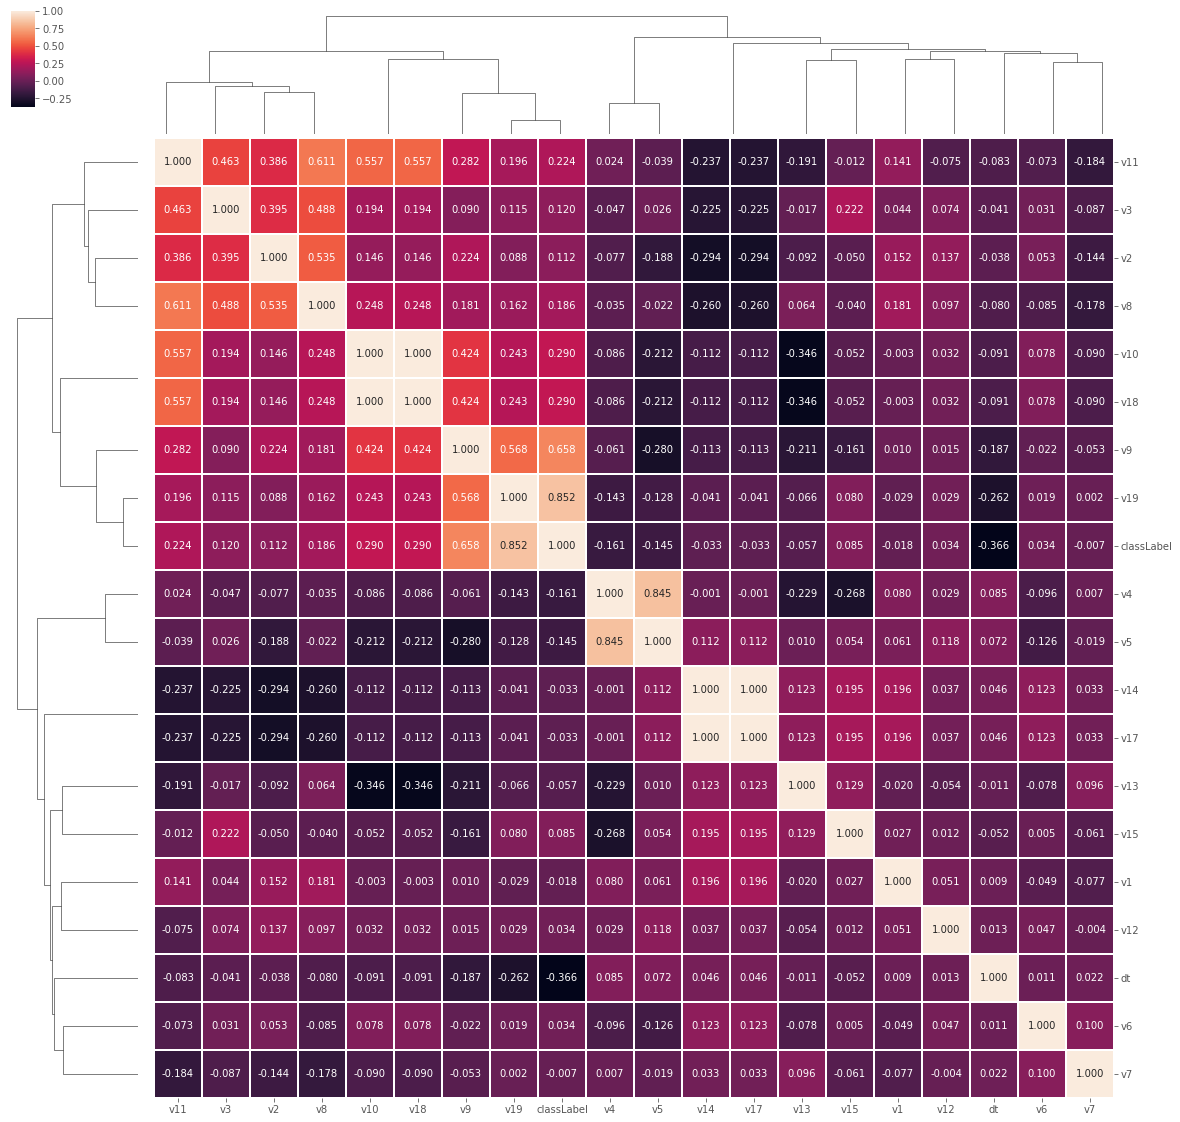

In [65]:
g = sns.clustermap(df_encoded.corr(), linewidths=1, square=True, annot=True, fmt=".3f", figsize = (20, 20))
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0);

In [66]:
df_final = df_encoded.drop(['v19', 'v18', 'v17'], 1)
df_final.head()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,classLabel,dt
0,0,17.92,0.000054,1,0,2,7,1.75,0,1,1,1,0,80.0,5,0,0
2,1,31.25,0.000112,1,0,6,2,0.00,0,1,1,0,0,96.0,19,0,0
4,1,32.33,0.000350,1,0,9,7,0.50,0,0,0,1,0,232.0,0,0,0
5,0,34.83,0.000125,2,2,7,3,0.50,0,0,0,1,0,160.0,0,0,0
10,0,24.75,0.001366,1,0,11,3,1.50,0,0,0,0,0,280.0,1,0,0


# Checking Class Weights - (Skewness)

The current data has a skewness. If we have really worst result, we can apply some sampling methods (oversampling, undersampling) to overcome that problem.

classLabel
0    0.108597
1    0.891403
Name: classLabel, dtype: float64

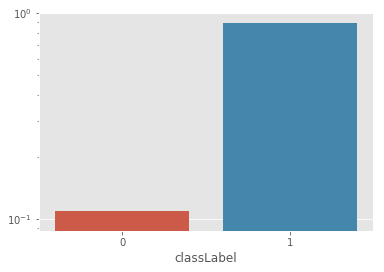

In [129]:
grouped_by_classlabel = df_final.groupby('classLabel')['classLabel']

p = grouped_by_classlabel.size() / len(df_final)
sns.barplot(x=p.index, y=p.values, log=True)
display(p)

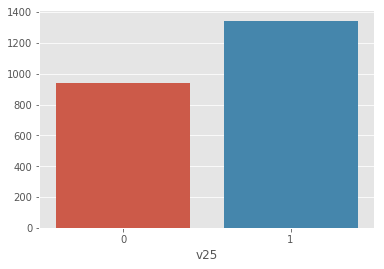

In [154]:
ros = RandomOverSampler(0.7)
X = df_train_final.drop('classLabel', 1)
y = df_train_final['classLabel']

X_resampled, y_resampled = ros.fit_sample(X, y)

df_oversampled = pd.DataFrame(list(map(lambda x: tuple(x), X_resampled)), columns= X.columns)
df_oversampled['v25'] = y_resampled

grouped_by_classlabel = df_oversampled.groupby('v25')['v25']
sns.barplot(x=grouped_by_classlabel.size().index, y=grouped_by_classlabel.size().values)

Best Classifier: {'n_estimators': 10, 'max_features': 'sqrt', 'class_weight': 'balanced', 'max_depth': 15, 'criterion': 'entropy'}
--------------------Testing Performance--------------------
             precision    recall  f1-score   support

          0       0.87      0.82      0.84        49
          1       0.76      0.83      0.79        35

avg / total       0.83      0.82      0.82        84

acc:  0.821428571429
--------------------Training Performance--------------------
             precision    recall  f1-score   support

          0       1.00      0.99      1.00       119
          1       1.00      1.00      1.00      1344

avg / total       1.00      1.00      1.00      1463

acc:  0.999316473001


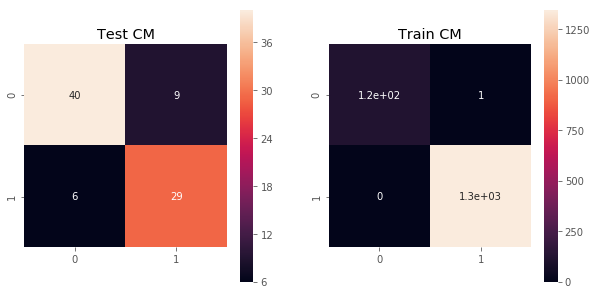

In [159]:
df_train_final = df_final[df_encoded['dt'] == 0].drop(['dt'], 1)
df_val_final = df_final[df_encoded['dt'] == 1].drop(['dt'], 1)

X_train = df_train_final.drop('classLabel', 1).values.tolist()
y_train = df_train_final['classLabel'].values.tolist()

X_test = df_val_final.drop('classLabel', 1).values.tolist()
y_test = df_val_final['classLabel'].values.tolist()

clf = RandomForestClassifier(n_jobs=-1) 

param_grid = { 
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [5, 15],
    'class_weight' : ['balanced', 'balanced_subsample']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 10)
CV_rfc = CV_rfc.fit(X_train, y_train)

print('Best Classifier: {}'.format(CV_rfc.best_params_))

report_classification(CV_rfc.best_estimator_, X_train, y_train, X_test, y_test)

Most importance features ordered by importance
['v9', 'v11', 'v3', 'v15', 'v8', 'v2', 'v14', 'v6', 'v10', 'v7', 'v4', 'v12', 'v1', 'v5', 'v13']


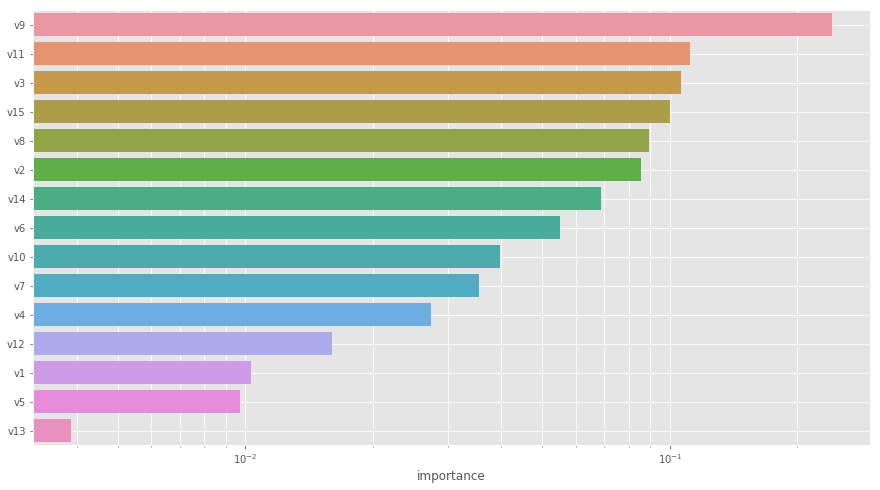

In [162]:
plot_importances(CV_rfc.best_estimator_, df_train_final, 'classLabel')

In [164]:
dump_pickle(encoder, '../../resources/encoder.pkl')
dump_pickle(CV_rfc.best_estimator_, '../../resources/model.pkl')

columns = df_train_final.drop(['classLabel'], 1).columns.values.tolist()
dump_pickle(columns, '../../resources/columns.pkl')

df_train_final.to_csv('../../resources/train.csv', index=False)
df_val_final.to_csv('../../resources/validation.csv', index=False)

In [166]:
!ls -l /resources/

total 292
-rw-r--r-- 1 root root    149 Aug 11 15:28 columns.pkl
-rw-r--r-- 1 root root   1566 Aug 10 21:02 encoder.p
-rw-r--r-- 1 root root   4301 Aug 11 15:28 encoder.pkl
-rw-r--r-- 1 root root 127963 Aug 10 21:02 model.p
-rw-r--r-- 1 root root  61462 Aug 11 15:28 model.pkl
-rw-r--r-- 1 root root  75608 Aug 11 15:28 train.csv
-rw-r--r-- 1 root root   4343 Aug 11 15:28 validation.csv
